# Amazon Fine Food Review- Using TruncatedSvd

In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sqlite3
con = sqlite3.connect("finalassignment.sqlite")

In [3]:
# Select data from table "Review"
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [4]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")

In [5]:
# To look at each class count
cleaned_data["Score"].value_counts() 

positive    307061
negative     57110
Name: Score, dtype: int64

In [6]:
# Select first 100k data-points
final = cleaned_data.iloc[:10000,:]
final.shape

(10000, 12)

# TF-IDF

In [7]:
# Data
X = final["CleanedText"]
X.shape

(10000,)

In [8]:
# Featurization
tfidf = TfidfVectorizer(use_idf = True, max_df = 0.80)
feat = tfidf.fit_transform(X)
feat.shape

(10000, 15482)

In [9]:
# Standardization
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(feat)
std_data

<10000x15482 sparse matrix of type '<class 'numpy.float64'>'
	with 303394 stored elements in Compressed Sparse Row format>

In [10]:
# List of vocabulary
list(tfidf.vocabulary_.keys())[0:10]

['witti',
 'littl',
 'book',
 'make',
 'son',
 'laugh',
 'loud',
 'recit',
 'car',
 'drive']

In [11]:
# List of vocabulary values 
list(tfidf.vocabulary_.values())[0:10]

[15122, 7899, 1464, 8144, 12485, 7661, 7997, 11007, 2006, 4131]

In [12]:
# Get feature names from tfidf
features = tfidf.get_feature_names()
# feature weights based on idf score
coef = tfidf.idf_
# Store features with their idf score in a dataframe
coeff_df = pd.DataFrame({'Features' : features, 'Idf_score' : coef})
coeff_df = coeff_df.sort_values("Idf_score", ascending = True)[:2000]
print("shape of selected features :", coeff_df.shape)
print("Top 5 features :\n\n",coeff_df[0:10])

shape of selected features : (2000, 2)
Top 5 features :

       Features  Idf_score
13378     tast   2.160694
7815      like   2.219863
5799      good   2.374071
5934     great   2.428467
5101    flavor   2.465005
9441       one   2.475444
8004      love   2.489979
14011      tri   2.555523
14466      use   2.586798
8144      make   2.658203


In [13]:
# Calculate Co-Occurrence Matrix
# with windows size 1 in forward and backward pass
# https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix?noredirect=1&lq=1
# https://cs224d.stanford.edu/lecture_notes/notes1.pdf
# just for sanity checks
import pandas as pd
import numpy as np
sentence = "I enjoy flying .", "I like NLP .", "I like deep learning ."
wrd = "I", "like", "enjoy", "deep", "learning", "NLP", "flying", "."
zero = np.zeros((len(wrd), len(wrd)))
df_zero = pd.DataFrame(zero, index = wrd, columns = wrd)
window = 1
for sent in sentence:
    word = sent.split(" ")
    for idx, dumb in enumerate(word):
            for j in range(max(idx-window,0),min(idx+window,len(word))):
                if (word[j] != word[idx]):
                        try:
                            df_zero.loc[word[idx], word[j]] += 1
                            df_zero.loc[word[j], word[idx]] += 1
                        except:
                            pass
print(df_zero)

            I  like  enjoy  deep  learning  NLP  flying    .
I         0.0   2.0    1.0   0.0       0.0  0.0     0.0  0.0
like      2.0   0.0    0.0   1.0       0.0  1.0     0.0  0.0
enjoy     1.0   0.0    0.0   0.0       0.0  0.0     1.0  0.0
deep      0.0   1.0    0.0   0.0       1.0  0.0     0.0  0.0
learning  0.0   0.0    0.0   1.0       0.0  0.0     0.0  1.0
NLP       0.0   1.0    0.0   0.0       0.0  0.0     0.0  1.0
flying    0.0   0.0    1.0   0.0       0.0  0.0     0.0  1.0
.         0.0   0.0    0.0   0.0       1.0  1.0     1.0  0.0


In [14]:
# https://cs224d.stanford.edu/lecture_notes/notes1.pdf
# co-occurence matrix
co_occurence_matrix = np.zeros((len(coeff_df), len(coeff_df)))
print(co_occurence_matrix.shape)
df = pd.DataFrame(co_occurence_matrix, index = coeff_df["Features"], columns = coeff_df["Features"])
df.shape

(2000, 2000)


(2000, 2000)

In [15]:
# Calculate Co-Occurrence Matrix 
# with windows size 4 in forward and backward pass
%time
window_size = 4
for sent in final["CleanedText"].str.decode("utf-8"):
    word = sent.split(" ")
    for i, d in enumerate(word):
        for j in range(max(i - window_size, 0), min(i + window_size, len(word))):
            if (word[i] != word[j]):
                    try:
                        df.loc[word[i], word[j]] += 1
                        df.loc[word[j], word[i]] += 1
                    except:
                        pass

Wall time: 0 ns


In [16]:
df.head()

Features,tast,like,good,great,flavor,one,love,tri,use,make,...,that,lavazza,taco,wont,outer,gather,stumbl,primari,pepperi,infect
Features,,,,,,,,,,,,,,,,,,,,,
tast,0.0,1903.0,1215.0,1143.0,561.0,370.0,475.0,380.0,351.0,373.0,...,2.0,7.0,4.0,5.0,4.0,0.0,0.0,6.0,16.0,4.0
like,1903.0,0.0,522.0,296.0,785.0,563.0,361.0,425.0,331.0,263.0,...,10.0,3.0,6.0,2.0,2.0,4.0,0.0,0.0,4.0,0.0
good,1215.0,522.0,0.0,300.0,514.0,333.0,197.0,294.0,218.0,384.0,...,9.0,2.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0
great,1143.0,296.0,300.0,0.0,529.0,193.0,330.0,187.0,240.0,418.0,...,2.0,0.0,8.0,2.0,0.0,0.0,2.0,0.0,0.0,6.0
flavor,561.0,785.0,514.0,529.0,0.0,424.0,369.0,481.0,358.0,245.0,...,2.0,6.0,0.0,0.0,0.0,0.0,2.0,8.0,8.0,0.0


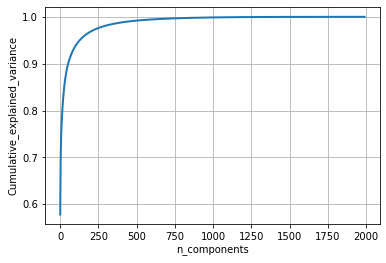

In [17]:
# TrucatedSVD
from sklearn.decomposition import TruncatedSVD
ts = TruncatedSVD(n_components = 1990)
ts_data = ts.fit_transform(df)

percentage_var_explained = ts.explained_variance_ / np.sum(ts.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

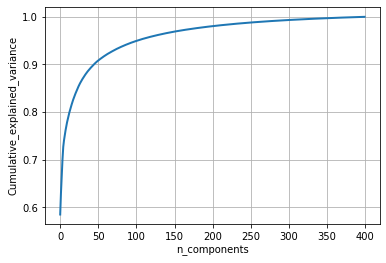

In [18]:
# TrucatedSVD
from sklearn.decomposition import TruncatedSVD
ts = TruncatedSVD(n_components = 400)
ts_data = ts.fit_transform(df)

percentage_var_explained = ts.explained_variance_ / np.sum(ts.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [19]:
# Elbow method to find K 
def find_optimal_k(data):
    loss = []
    k = list(range(2, 15, 2))
    for noc in k:
        model = KMeans(n_clusters = noc)
        model.fit(data)
        loss.append(model.inertia_)
    plt.plot(k, loss, "-o")
    plt.title("Elbow method to choose k")
    plt.xlabel("K")
    plt.ylabel("Loss")
    plt.show()

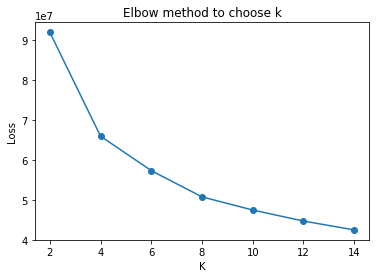

In [20]:
# Find best k using elbow method
find_optimal_k(ts_data)

In [21]:
# After applying truncated svd store data into dataframe
df = pd.DataFrame(ts_data)

In [22]:
# Data shape
df.shape

(2000, 400)

In [23]:
# K-means clustering
clf = KMeans(n_clusters = 10)
clf.fit(ts_data)

KMeans(n_clusters=10)

In [24]:
# Assign each data-points with its correspondincg label
df["Cluster_labels"] = clf.labels_
df["Words"] = coeff_df["Features"].values     
df.head()     

,0,1,2,3,4,5,6,7,8,9,...,392,393,394,395,396,397,398,399,Cluster_labels,Words
0,3014.647073,1641.439589,-397.390794,322.307223,-606.373771,282.320373,8.994289,32.110627,-156.161396,21.739653,...,0.052695,0.114886,0.032044,-1.132199,-0.006008,0.358757,-0.340180,-0.036241,4,tast
1,2779.588171,-1326.851960,-5.422670,270.202523,-457.760563,172.426366,5.645560,169.327213,343.890761,-80.705711,...,-0.114716,0.739165,0.629751,0.473311,-0.274384,0.071294,-0.289801,-0.266213,9,like
2,2077.426490,-682.011349,34.171522,6.544899,-327.248207,155.447743,-61.856986,-45.039047,-165.575003,46.813398,...,-0.896191,-1.169274,0.475262,-0.760833,-1.564710,0.080218,0.361590,0.575129,2,good
3,1832.183724,-739.154006,82.829433,-117.960860,-234.558344,96.822683,-99.399266,-164.322042,-315.383432,141.778466,...,0.555039,-0.620928,-0.239947,0.003617,1.020015,-0.743384,0.289256,-0.991928,2,great
4,2168.157642,347.441992,-347.672398,428.924126,-49.757214,76.261017,69.371392,-88.700542,550.638669,-5.636074,...,0.378575,-1.184618,-0.318081,0.434788,0.097984,-0.150334,-0.784323,-0.510449,3,flavor


In [34]:
# Plotting word cloud
def plot_word_cloud(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    # Remove duplicate words
    stopwords = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of top words")
    plt.tight_layout(pad = 0)
    plt.show()

total number of word in cluster 0 is 1491


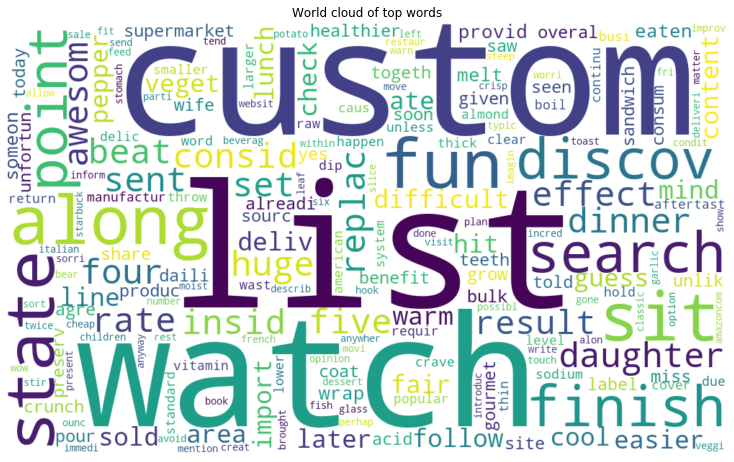

total number of word in cluster 1 is 21


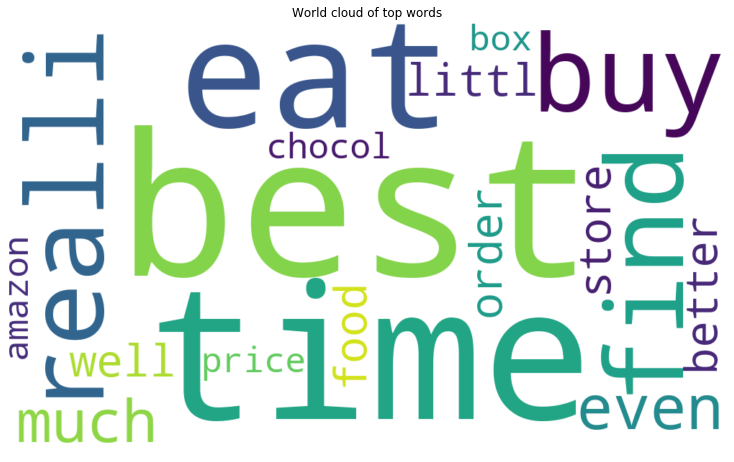

total number of word in cluster 2 is 2


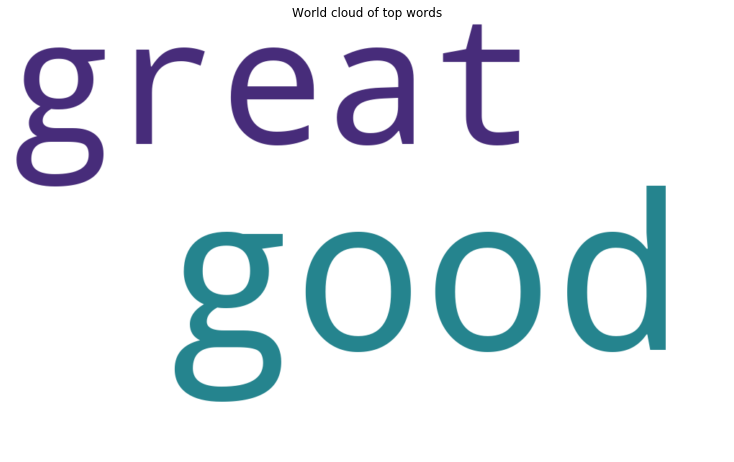

total number of word in cluster 3 is 8


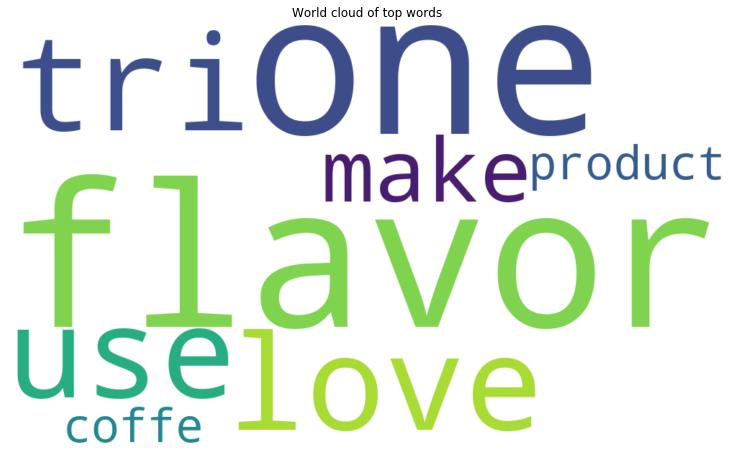

total number of word in cluster 4 is 1


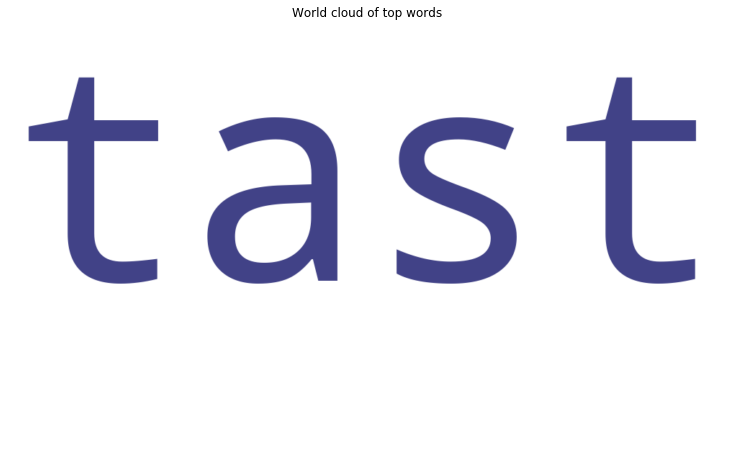

total number of word in cluster 5 is 332


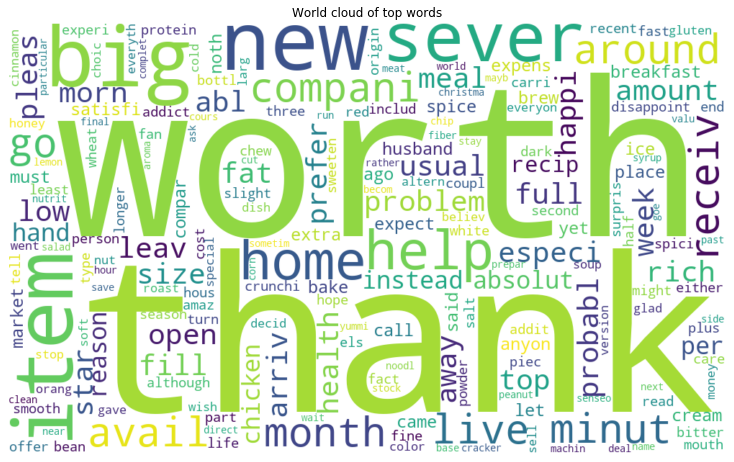

total number of word in cluster 6 is 105


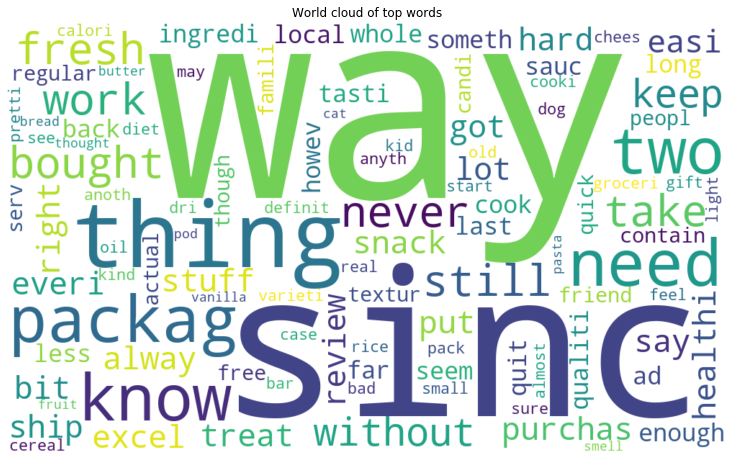

total number of word in cluster 7 is 1


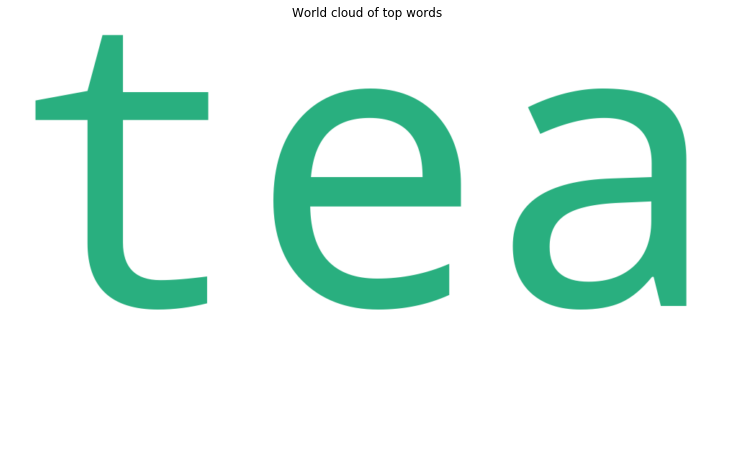

total number of word in cluster 8 is 38


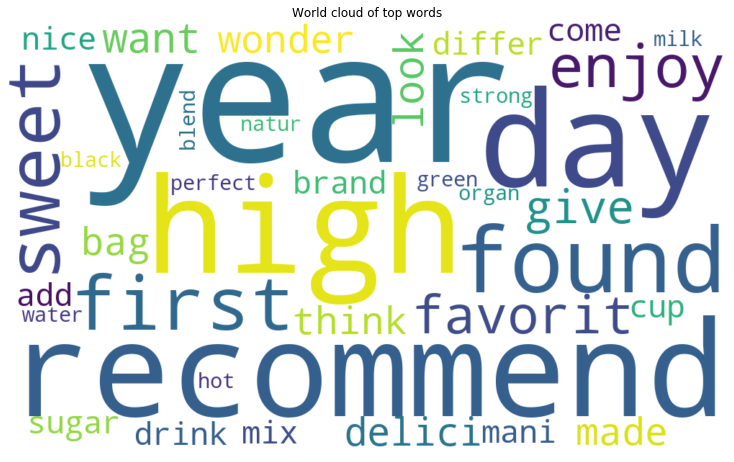

total number of word in cluster 9 is 1


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [36]:
# print word cloud of each cluster
for i in range(clf.n_clusters):
    l = list()
    # Groups each label
    label = df.groupby(["Cluster_labels"]).groups[i]
    # store each word from a particular label in a list and pass it word cloud method
    for j in range(len(label)):
        l.append(df.loc[label[j]]["Words"])
    print("total number of word in cluster {} is {}".format(i, len(label)))    
    plot_word_cloud(l)

In [27]:
# Calculate cosine similarity
from sklearn.metrics import pairwise_distances
def cosine_similarity(word_index, total_results):
    # calculate pairwise distances from given word
    # The smaller the distance, the more similar the word
    dist = pairwise_distances(ts_data, ts_data[word_index:word_index + 1,:])
    # Store index of the distances
    indices = np.argsort(dist.flatten())[0:total_results]
    # Sort distances 
    pdist = np.sort(dist.flatten())[0:total_results]
    # put indices at particular index of dataframe
    df_indices = list(df.index[indices])
    print("Most_Similar Words \t Distances")
    # Loop through indices and find match
    for i in range(len(indices)): 
        if indices[i] == df.index[indices[i]]:
            print(df.Words.loc[indices[i]], "\t\t\t", dist[indices[i]])

In [28]:
# given index of a word
# find how similar words are from this index word
cosine_similarity(119, 7)

Most_Similar Words 	 Distances
regular 			 [0.]
kind 			 [229.17559276]
almost 			 [233.97545513]
howev 			 [236.01071837]
actual 			 [239.46623003]
lot 			 [243.13005721]
usual 			 [249.7833443]


In [29]:
# given index of a word
# find how similar words are from this index word
cosine_similarity(56, 7)

Most_Similar Words 	 Distances
ever 			 [0.]
far 			 [601.85823441]
found 			 [655.71554871]
think 			 [720.47932589]
brand 			 [721.73349106]
thing 			 [724.19230254]
say 			 [732.61696647]
